<a href="https://colab.research.google.com/github/okana2ki/intro-to-AI/blob/main/student_faculty_assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 課題（学生-教員割り当て問題）について

新入生が書いた作文から判断して、作文の内容と関連する大学教員に新入生を割り当てる問題を考える。作文は将来希望する職業、その理由、それに向けて大学で学びたいことなどが書かれている。これまでは人手で割り当てを実施してきたが、割り当て案の自動作成を試みる。

[**埋め込み**（文章の内容を表す特徴ベクトル）を文章から生成する技術](https://www.sbert.net/)を利用する。この技術は従来のキーワードマッチングや、キーワードをベクトルで表す技術（word2vecなど）と比べて高い精度で文章の内容を表現できる。

新入生が書いた作文を埋め込みに変換したものと、教員の特徴を表す文章を埋め込みに変換したものを比較し、新入生を埋め込みが近い教員に割り当てる。

教員の特徴を表す文章としては、大学のHPの[教員紹介ページ](https://www.miyasankei-u.ac.jp/kyouin-introduce/)に掲載された情報を用いる。

# Text Embeddingを用いた文章の類似度計算

## 日本語で利用可能なtext embeddingモデルの例

以下は、日本語で利用可能なtext embeddingモデルの例です（出典：NLP2024チュートリアル, 松田寛）

日本語のモデル：

SimCSE, Gao+ (2021/04) をベースにしたもの

Japanese SimCSE (BERT-base) (2022/12)

Japanese Simple-SimCSE, Tsukagoshi+ (2023/10)

ColBERT, Khattab+ (2020/04) をベースにしたもの

JaColBERT, Clavié (2023/12)

多言語モデルの例：

multilingual-e5-large, Wang+ (2024/02)

## 日本語のtext embeddingモデルについての追加情報（2025年5月）

- [テキスト埋め込みモデルPLaMo-Embedding-1B](https://a03.hm-f.jp/index.php?action=ViewPublicBnMail&mid=99&gid=15&aid=946&bn_code=847b025ee8c0f2d5466573219aa1245f)


## Japanese SimCSE (BERT-base) モデルのロード

 このノートブックでは、text embeddingモデルとして、[Japanese SimCSE (BERT-base) ](https://huggingface.co/pkshatech/simcse-ja-bert-base-clcmlp/blob/main/README_JA.md) を使用します。

 sentence-transformersを使って、このモデルを簡単に利用することができます。トークナイズのために、fugashiとunidic-liteが必要です。まず、下記のように、pipでsentence-transformersとfugashi, unidic-liteをインストールします。

In [ ]:
!pip install -U fugashi[unidic-lite]
!pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('pkshatech/simcse-ja-bert-base-clcmlp')

## モデルを利用した埋め込み (embedding) 作成例

In [ ]:
sentences = [
    "PKSHA Technologyは機械学習/深層学習技術に関わるアルゴリズムソリューションを展開している。",
    "この深層学習モデルはPKSHA Technologyによって学習され、公開された。",
    "広目天は、仏教における四天王の一尊であり、サンスクリット語の「種々の眼をした者」を名前の由来とする。",
]

embeddings = model.encode(sentences)
print(embeddings)

## 類似度はcosine類似度がお勧め

Japanese SimCSE (BERT-base) モデルは、学習時の損失関数にcosine類似度を使っているため、下流のタスクで**cosine類似度を類似度計算に使うことをおすすめ**します。とのとです。

# 割り当てタスク用プログラム

## 教員情報の処理


教員情報は、HPの教員紹介ページに掲載されている内容を使用した。教員が内容の更新を希望した場合は、加筆修正を施した。さらに、割り当て結果改善のため、追加キーワードを付加した。教員情報の見出しの後ろにコロンを追加（コロンがある方が埋め込みへの変換がより適切に行われるのではないかと考えて）し、これをCSVファイルに格納した。

### 1. 教員CSVファイルからfa_sentencesを作成

In [7]:
# prompt: ネット上のファイル https://github.com/okana2ki/ML/blob/main/2024faculty.csv を読み込み

import pandas as pd

# CSVファイルの読み込み
url = 'https://raw.githubusercontent.com/okana2ki/ML/main/2025faculty.csv'
faculty_df = pd.read_csv(url)
# faculty_df = pd.read_csv(faculty_csv_path, encoding='shift_jis')

# NaNやNoneを含む可能性がある行を削除 <- エラー対策
faculty_df = faculty_df.dropna(subset=['description'])

# description列からsentencesリストを生成
fa_sentences = faculty_df['description'].tolist()

# sentencesの各要素が文字列であることを確認 <- エラー対策
fa_sentences = [str(sentence) for sentence in fa_sentences]

In [8]:
faculty_df.head()

,id,name,description,pair,similarity
0,0,iwakiri,プロフィール：\n宮崎県出身です。宮崎県庁で工業支援、観光振興、ＮＰＯ活動促進、民間と行政と...,NaN,NaN
1,1,uchida,プロフィール：\n兵庫県出身。宮崎大学大学院農学工学総合研究科物質･情報工学専攻博士後期課程...,NaN,NaN
2,2,oouchi,プロフィール：\r\n宮城県出身、宮城大学事業構想学研究科博士後期課程修了、博士（事業構想学...,NaN,NaN
3,3,oka,プロフィール：\n出身は徳島で、東京と京都暮らしを経て宮崎に来ました。企業と大学でAI（人工...,NaN,NaN
4,4,okumura,プロフィール：\n宮崎県出身、東京工業大学工学部社会工学科卒業、ハーバード大学大学院公共政策...,NaN,NaN


In [9]:
print(fa_sentences) # 内容確認用

['プロフィール：\n宮崎県出身です。宮崎県庁で工業支援、観光振興、ＮＰＯ活動促進、民間と行政との協働、福祉、保健などに従事しました。働きながら、大学院で学び、研究を仕事に生かし、仕事を研究に生かしてきました。この経験を学生の皆さんの学びに活かしていきたいと思います。\n\n担当科目：\n経営戦略論Ａ・Ｂ、商学概論Ａ・Ｂ、経営シミュレーション、ボランティア、特別講義\n\nゼミナールテーマ：\n企業の経営戦略を研究し、実践で使える戦略を立案します。\n\n学生へのメッセージ：\n大学生活は、人生の中でとても実りある大事な時間です。この期間を明るく、楽しく、前向きに過ごして充実させてください。たくさんのチャレンジをしながら、大学での学び、サークル、人との出会いなどを通じて、卒業後に人生を豊かにするものと出逢ってください。\n\nその他(顧問等)：\n地域活性化サークル\n\n関連キーワード：\nマーケティング、流通、地域活性化、公務員\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u3000\u

### 2. 埋め込みを生成

In [10]:
fa_embeddings = model.encode(fa_sentences)

In [11]:
print(fa_embeddings) # 内容確認用
print(type(fa_sentences)) # debug用
fa_embeddings.shape # debug用

[[ 0.2565857   0.0458958  -0.15770756 ... -0.45967117 -0.09506368
   0.02200329]
 [ 0.28387603 -0.03769646 -0.07489893 ... -0.36349452  0.22956428
   0.35593322]
 [ 0.3265475   0.15546954 -0.09428808 ... -0.45420322 -0.18357228
   0.28610498]
 ...
 [ 0.22673072 -0.32228845 -0.6123862  ...  0.08751058  0.26731113
   0.03532458]
 [-0.04642327  0.25242266 -0.05341915 ... -0.14016968  0.17206125
  -0.00415956]
 [ 0.47107002 -0.0274118  -0.4139816  ... -0.56421137 -0.27589464
  -0.12221539]]
<class 'list'>


(23, 768)

### 3A. Google Driveにembeddingsを保存するプログラム

GPUが使えない場合に備えて、一度計算したembeddingを保存して利用できるようにした。

In [ ]:
import os
import torch

# 保存するディレクトリのパスを指定（存在しない場合は作成）
save_dir = '/content/drive/MyDrive/Colab_files'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# ファイルに保存
file_path = os.path.join(save_dir, 'fa_embeddings.pt')
torch.save(fa_embeddings, file_path)

print(f'embeddingsが{file_path}に保存されました。')

### 3B. Google Driveからembeddingsを読み出すプログラム

In [ ]:
import os
import torch

# 読み出すファイルのパスを指定
file_path = '/content/drive/MyDrive/Colab_files/fa_embeddings.pt'

# ファイルが存在するか確認
if os.path.exists(file_path):
    # ファイルから読み出し
    fa_embeddings = torch.load(file_path)
    print(f'embeddingsが{file_path}から読み出されました。サイズ: {fa_embeddings.shape}')
else:
    print(f'{file_path}が見つかりません。ファイルパスを確認してください。')


In [ ]:
print(type(fa_sentences)) # debug用
fa_embeddings.shape # debug用

### 4. コサイン類似度の確認

（割り当て作業には必要ないが）コサイン類似度が類似度の指標として妥当であることの確認用

その１：コサイン類似度で、ある教員と全教員との類似度を計算した後で、全教員を類似度の降順で並べて、faculty.csvのname列の名前で表示する

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

# 例として、3番目の教員をクエリとして使用し他の教員とのコサイン類似度を計算
# query_embedding = fa_embeddings[0].reshape(1, -1)  # 最初の教員の埋め込みベクトル
query_embedding = fa_embeddings[3].reshape(1, -1)
similarity_scores = cosine_similarity(query_embedding, fa_embeddings).flatten()

# 類似度スコアに基づいて文書のインデックスを降順にソート
sorted_doc_indices = similarity_scores.argsort()[::-1]

# 類似度の降順に名前と類似度スコアを表示
print("全教員を類似度の降順で表示:")
for idx in sorted_doc_indices:
    print(f"{faculty_df['name'].iloc[idx]}: {similarity_scores[idx]:.4f}")

全教員を類似度の降順で表示:
oka: 1.0000
motomura: 0.8594
uchida: 0.8147
iwakiri: 0.8140
kawashima: 0.8091
oouchi: 0.7961
shiraishi: 0.7932
morita: 0.7460
yuhara: 0.7341
ideyama: 0.7108
yamanashi: 0.6759
taketsugu: 0.6728
tanaka: 0.6724
okumura: 0.6719
honda: 0.6692
hagihara: 0.6473
miyashita: 0.6324
kuraya: 0.6282
yasui: 0.6242
saiga: 0.6108
horishita: 0.6106
sumi: 0.5908
wakamatsu: 0.5144


その２：コサイン類似度で階層的クラスタリング

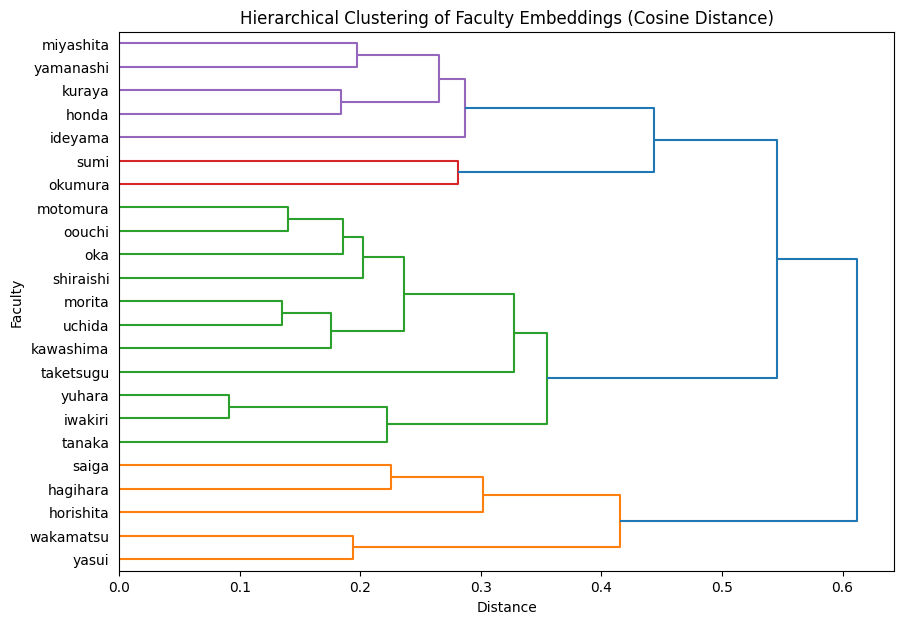

Cluster 1:
  - yasui
  - wakamatsu

Cluster 2:
  - hagihara
  - saiga
  - horishita

Cluster 3:
  - iwakiri
  - tanaka
  - yuhara

Cluster 4:
  - uchida
  - oouchi
  - oka
  - kawashima
  - shiraishi
  - taketsugu
  - motomura
  - morita

Cluster 5:
  - okumura
  - sumi

Cluster 6:
  - ideyama
  - honda
  - yamanashi
  - kuraya
  - miyashita



In [13]:
# prompt: ユークリッド距離でなく、コサイン類似度で階層的クラスタリング

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

# コサイン距離行列を計算；コサイン距離 = 1 - コサイン類似度；値の範囲は 0 から 2
cosine_distances = pdist(fa_embeddings, metric='cosine')

# 階層的クラスタリングを実行 (ward法を使用)
linkage_matrix = linkage(cosine_distances, method='ward')

# デンドログラムを描画
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=faculty_df['name'].tolist(), orientation='right')
plt.title('Hierarchical Clustering of Faculty Embeddings (Cosine Distance)')
plt.xlabel('Distance')
plt.ylabel('Faculty')
plt.show()

# クラスタ数を指定してクラスタラベルを取得 (例: クラスタ数6)
num_clusters = 6
cluster_labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# クラスタごとに教員名を表示
for cluster_id in range(1, num_clusters + 1):
    print(f"Cluster {cluster_id}:")
    cluster_indices = [i for i, label in enumerate(cluster_labels) if label == cluster_id]
    for idx in cluster_indices:
        print(f"  - {faculty_df['name'].iloc[idx]}")
    print()

その３：演習問題：問い合わせに対して適切な教員を紹介するプログラムを作成しなさい。問い合わせを埋め込みに変換し、コサイン類似度が近い上位5名の教員名を順番を付けて表示して下さい。

In [16]:
# prompt: 問い合わせに対して適切な教員を紹介するプログラムを作成しなさい。問い合わせを埋め込みに変換し、コサイン類似度が近い上位5名の教員名を順番を付けて表示して下さい。

# 問い合わせを入力
query = input("興味のある研究分野やテーマ、質問、将来どのような仕事をしたいか等を入力してください: ")

# 問い合わせを埋め込みに変換
query_embedding = model.encode(query).reshape(1, -1)

# 教員の埋め込みとのコサイン類似度を計算
similarity_scores = cosine_similarity(query_embedding, fa_embeddings).flatten()

# 類似度スコアに基づいて教員のインデックスを降順にソート
sorted_indices = similarity_scores.argsort()[::-1]

# 上位5名の教員を表示
print("\nあなたにおすすめの教員:")
for i in range(5):
    idx = sorted_indices[i]
    print(f"{i+1}. {faculty_df['name'].iloc[idx]} (類似度: {similarity_scores[idx]:.4f})")

興味のある研究分野やテーマ、質問、将来どのような仕事をしたいか等を入力してください: オリンピックで金メダル

あなたにおすすめの教員:
1. wakamatsu (類似度: 0.4065)
2. yamanashi (類似度: 0.2869)
3. sumi (類似度: 0.2693)
4. horishita (類似度: 0.2658)
5. saiga (類似度: 0.2566)


## 学生情報の処理



### 0. 学生情報の準備

まず、元のデータから、重複行を取り除く。これは、一人の学生が、2回以上データをアップロードしてよい設定になっているために必要になる前処理である。そのような複数回アップロードされたデータがあれば、タイムスタンプが一番新しい行だけを残し、他の行は削除する。

元の学生情報ファイルでは、学生による入力情報が複数セルに分けて記入されているため、これを1セル（descriptionf列のセル）にまとめておいて、それを埋め込みに変換する方針とする。

GPT-4への指示：

添付ファイルのdescription列に、次の内容を書きこんで下さい。

将来希望する職業：各行の第5列の内容をここに転載

この職業を希望する理由：各行の第6列の内容をここに転載

自分の将来：各行の第7列の内容をここに転載

In [ ]:
# CSVファイルの読み込み
# student_csv_path = '/content/drive/MyDrive/Colab_files/2023students_original.csv'  # 適切なパスに変更してください
# student_csv_path = '/content/drive/MyDrive/Colab_files/2024students_original.csv'  # 適切なパスに変更してください
student_csv_path = '/content/drive/MyDrive/Colab_files/2025students_original.csv'  # 適切なパスに変更してください
df = pd.read_csv(student_csv_path)

# Filling the description column with the required information
df['description'] = df.apply(lambda row: f"将来希望する職業：{row['将来希望する職業は何ですか？']}\nこの職業を希望する理由：{row['その職業を希望する理由はなんですか。']}\n自分の将来：{row['『自分の将来を考えよう』']}", axis=1)

# Save the modified dataframe to a new CSV file
# output_file_path = '/content/drive/MyDrive/Colab_files/2023students.csv'
# output_file_path = '/content/drive/MyDrive/Colab_files/2024students.csv'
output_file_path = '/content/drive/MyDrive/Colab_files/2025students.csv'
df.to_csv(output_file_path, index=False)

output_file_path

df

### 1. 学生CSVファイルからsentencesを作成

In [ ]:
import pandas as pd

# CSVファイルの読み込み
# student_csv_path = '/content/drive/MyDrive/Colab_files/2023students.csv'  # 適切なパスに変更してください
# student_csv_path = '/content/drive/MyDrive/Colab_files/2024students.csv'  # 適切なパスに変更してください
student_csv_path = '/content/drive/MyDrive/Colab_files/2025students.csv'  # 適切なパスに変更してください
student_df = pd.read_csv(student_csv_path)
# faculty_df = pd.read_csv(faculty_csv_path, encoding='shift_jis')

# NaNやNoneを含む可能性がある行を削除 <- エラー対策
student_df = student_df.dropna(subset=['description'])

# description列からsentencesリストを生成
st_sentences = student_df['description'].tolist()

# sentencesの各要素が文字列であることを確認 <- エラー対策
st_sentences = [str(sentence) for sentence in st_sentences]

In [ ]:
print(st_sentences) # 確認用

### 2. 埋め込みを生成

In [ ]:
st_embeddings = model.encode(st_sentences)

### Google Driveにembeddingsを保存するプログラム

In [ ]:
import os
import torch

# 保存するディレクトリのパスを指定（存在しない場合は作成）
save_dir = '/content/drive/MyDrive/Colab_files'  # 'your_directory'は適宜変更してください
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# ファイルに保存
file_path = os.path.join(save_dir, 'st_embeddings.pt')
torch.save(st_embeddings, file_path)

print(f'embeddingsが{file_path}に保存されました。')

### Google Driveからembeddingsを読み出すプログラム

In [ ]:
import os
import torch

# 読み出すファイルのパスを指定
file_path = '/content/drive/MyDrive/Colab_files/st_embeddings.pt'

# ファイルが存在するか確認
if os.path.exists(file_path):
    # ファイルから読み出し
    st_embeddings = torch.load(file_path)
    print(f'embeddingsが{file_path}から読み出されました。サイズ: {st_embeddings.shape}')
else:
    print(f'{file_path}が見つかりません。ファイルパスを確認してください。')

In [ ]:
st_embeddings.shape # debug用

## 学生の教員への割り当て

### 1. コサイン類似度で全学生-全教員間の類似度を計算




以下の2種類のソート結果は、割り当てアルゴリズムでは使用しないが、埋め込みや類似度の妥当性の検討で使用。
*   各学生について降順でソート（類似した順に全教員を表示）
*   各教員について降順でソート（類似した順に全学生を表示）

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Convert tensors to numpy arrays for compatibility with sklearn
# The fa_embeddings and st_embeddings are already numpy arrays.
fa_embeddings_np = fa_embeddings
st_embeddings_np = st_embeddings

# Calculate cosine similarity
# The result will be a matrix of shape [98, 23] where each row corresponds to a student and each column to a faculty
# 2024年度は、93x23 → 重複があったので 92x23
# 2025年度は、97*23
cos_sim = cosine_similarity(st_embeddings_np, fa_embeddings_np)

# Sort similarities for each student
student_sorted_indices = np.argsort(-cos_sim, axis=1)  # Sort indices in descending order of similarity for each student

# Sort similarities for each faculty
faculty_sorted_indices = np.argsort(-cos_sim.T, axis=1)  # Sort indices in descending order of similarity for each faculty

student_sorted_indices, faculty_sorted_indices

学生ファイルにid列を付加

'/content/drive/MyDrive/Colab_files/2025students.csv'を読み込み、その3列目に'id'列を挿入し、その列に上から順に0から始まる番号を振り、'/content/drive/MyDrive/Colab_files/2025students_id.csv'に保存する。

In [ ]:
# prompt: '/content/drive/MyDrive/Colab_files/2025students.csv'を読み込み、その3列目に'id'列を挿入し、その列に上から順に0から始まる番号を振り、'/content/drive/MyDrive/Colab_files/2025students_id.csv'に保存する。

import pandas as pd

# CSVファイルの読み込み
df9 = pd.read_csv('/content/drive/MyDrive/Colab_files/2025students.csv')

# 'id'列の追加と番号付け
df9.insert(2, 'id', range(len(df)))

# 新しいCSVファイルに保存
df9.to_csv('/content/drive/MyDrive/Colab_files/2025students_id.csv', index=False)


GPT-4への指示：

上記の結果を、次の2つのファイルに書き加えて下さい。

2023students.csv: このファイルのsimilarity列に、類似した順に全ファカルティを表示して下さい。ファカルティはfaculty.csvのname列の名前（faculty.csvの掲載順とfa_embeddingsの掲載順は一致しています）で表示して下さい。

faculty.csv: このファイルのsimilarity列に、類似した順に全学生を表示して下さい。学生は2023students.csvのid列の番号（これst_はembeddingsの順番と一致しています）で表示して下さい。

In [ ]:
import pandas as pd

# Load the CSV files
# student_df = pd.read_csv('/content/drive/MyDrive/Colab_files/2023students.csv')
# student_df = pd.read_csv('/content/drive/MyDrive/Colab_files/2024students.csv')
student_df = pd.read_csv('/content/drive/MyDrive/Colab_files/2025students_id.csv')
faculty_df = pd.read_csv('/content/drive/MyDrive/Colab_files/2024faculty.csv')

# Verify the content of the files
student_df.head(), faculty_df.head()

In [ ]:
# Mapping faculty indices to names
faculty_names = faculty_df['name'].tolist()

# Updating the 'similarity' column for students with faculty names in descending similarity order
student_df['similarity'] = ['; '.join([faculty_names[i] for i in row]) for row in student_sorted_indices]

# Mapping student indices to their IDs
student_ids = student_df['id'].tolist()

# Updating the 'similarity' column for faculties with student IDs in descending similarity order
faculty_df['similarity'] = ['; '.join([str(student_ids[i]) for i in row]) for row in faculty_sorted_indices]

# Save the updated dataframes to new CSV files
# updated_students_csv_path = '/content/drive/MyDrive/Colab_files/updated_2023students.csv'
# updated_students_csv_path = '/content/drive/MyDrive/Colab_files/updated_2024students.csv'
# updated_faculty_csv_path = '/content/drive/MyDrive/Colab_files/updated_2024faculty.csv'
updated_students_csv_path = '/content/drive/MyDrive/Colab_files/updated_2025students.csv'
updated_faculty_csv_path = '/content/drive/MyDrive/Colab_files/updated_2025faculty.csv'

student_df.to_csv(updated_students_csv_path, index=False)
faculty_df.to_csv(updated_faculty_csv_path, index=False)

updated_students_csv_path, updated_faculty_csv_path

In [ ]:
student_df

In [ ]:
faculty_df

### 2. 割り当てアルゴリズム実行の準備

アルゴリズムの設計方針：何らかの損失関数を定義して最適化するのが正攻法だが、タスクの性質上、そこまでの精度は必要ないと判断し、計算量が小さい決定的なアルゴリズムを作ることにした。

まず、**上記で実行した結果を、以下のプログラムだけを実行したら利用できるようにする**。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch

# 読み出すファイルのパスを指定
file_path = '/content/drive/MyDrive/Colab_files/fa_embeddings.pt'

# ファイルが存在するか確認
if os.path.exists(file_path):
    # ファイルから読み出し
    fa_embeddings = torch.load(file_path)
    print(f'embeddingsが{file_path}から読み出されました。サイズ: {fa_embeddings.shape}')
else:
    print(f'{file_path}が見つかりません。ファイルパスを確認してください。')

In [ ]:
import os
import torch

# 読み出すファイルのパスを指定
file_path = '/content/drive/MyDrive/Colab_files/st_embeddings.pt'

# ファイルが存在するか確認
if os.path.exists(file_path):
    # ファイルから読み出し
    st_embeddings = torch.load(file_path)
    print(f'embeddingsが{file_path}から読み出されました。サイズ: {st_embeddings.shape}')
else:
    print(f'{file_path}が見つかりません。ファイルパスを確認してください。')

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Convert tensors to numpy arrays for compatibility with sklearn
# The fa_embeddings and st_embeddings are already numpy arrays.
fa_embeddings_np = fa_embeddings
st_embeddings_np = st_embeddings

# Calculate cosine similarity
# The result will be a matrix of shape [98, 23] where each row corresponds to a student and each column to a faculty
# 2024年度は、93x23 → 重複があったので 92x23
# 2025年度は、97*23
cos_sim = cosine_similarity(st_embeddings_np, fa_embeddings_np)

In [ ]:
import pandas as pd

# Load the CSV files
student_df = pd.read_csv('/content/drive/MyDrive/Colab_files/updated_2025students.csv')
faculty_df = pd.read_csv('/content/drive/MyDrive/Colab_files/updated_2025faculty.csv')

# Verify the content of the files
student_df.head(), faculty_df.head()

### 学生をファカルティに割り当てるアルゴリズム

アルゴリズムの目的：学生-ファカルティの1対1のペアを学生数分だけ作る。各学生は一人のファカルティとペアになる。各ファカルティが受け入れる学生数は、できるだけ平準化する。できるだけ類似度が高い学生とファカルティがペアになるようにする。

2025年の設計方針：以前のアルゴリズムによる割り当てを試行したところ、2025年の学生データの特徴として、学生群のデータに対して類似度が高めの教員と、低めの教員との差異がこれまでよりも大きく、低めの教員に対して類似していない学生への割り当てが多くなるという問題が顕在化した。このため、類似度が高いペア順に割り振りを決定する方針はそのままだが、以下の方針で設計し直した：
1. すべての教員に一人ずつ割り当てる
2. すべての教員に2人目を割り当てる
3. 以下、同様

アルゴリズムの手順：
1. 全学生-全ファカルティ間の埋め込みのコサイン類似度を計算する。
2. すべてを類似度の降順で一列にならべ、「ソート列」とする。
3. 次の手順で学生-ファカルティの1対1のペアを学生数分だけ作る。結果として学生は1つのペアに属する。ファカルティが受け入れる学生数はできるだけ平準化される。
4. 「登録済ペア」のリストを空に初期化する。「残ソート列」を空に初期化する。
5. 各ファカルティの「受け入れ学生数」をゼロに初期設定する。
6. 「ソート列」が空なら終了。空でなければ「ソート列」から先頭の1ペアを取り出す。「ソート列」は取り出した分短くなる。
7. 取り出したペアのファカルティの「受け入れ学生数」がゼロであれば8.に、ゼロでなければ10.に進む。
8. 取り出したペアを「登録済みペア」として登録し、画面出力する。ペアになったファカルティの「受け入れ学生数」を1にし、ペアとなった学生が属するペアの類似度データ全てを「ソート列」および「残ソート列」から削除する。
9. 「受け入れ学生数」がゼロのファカルティが残っていれば、6.に戻る。ゼロのファカルティが残っていなければ、「残ソート列」と「ソート列」をこの順にappendしたもの（「残ソート列」が先頭でその後ろに「ソート列」が続くようにしたもの）を新たな「ソート列」とする。さらに、「残ソート列」を空に初期化して、5.に戻る。
10. 7.で取り出したペアを「残ソート列」の先頭に挿入して、6.に戻る。




In [ ]:
# prompt: 上記のアルゴリズムを実装して下さい。動作確認のため、「登録済みペア」が増えるたびに画面出力するようにして下さい。

import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# ... (previous code) ...

# ### 2. 割り当てアルゴリズム

# ... (previous code, including loading embeddings and dataframes) ...


# Initialize variables
registered_pairs = []
remaining_sort_list = []
faculty_acceptance_counts = {faculty_name: 0 for faculty_name in faculty_df['name']}

# Create the initial sorted list of student-faculty pairs based on cosine similarity
sorted_pairs = []
for student_index in range(len(student_df)):
    for faculty_index in range(len(faculty_df)):
        sorted_pairs.append(
            (student_df['id'][student_index], faculty_df['name'][faculty_index], cos_sim[student_index][faculty_index])
        )
sorted_pairs = sorted(sorted_pairs, key=lambda x: x[2], reverse=True)

# Main loop of the assignment algorithm
while sorted_pairs:
    student_id, faculty_name, similarity = sorted_pairs.pop(0)

    if faculty_acceptance_counts[faculty_name] == 0:
        registered_pairs.append((student_id, faculty_name, similarity))
        faculty_acceptance_counts[faculty_name] = 1
        print(f"Registered Pair: Student {student_id} - Faculty {faculty_name} (Similarity: {similarity:.4f})")  # Output registered pairs

        # Remove student's other potential pairings from the sorted list and remaining_sort_list
        sorted_pairs = [pair for pair in sorted_pairs if pair[0] != student_id]
        remaining_sort_list = [pair for pair in remaining_sort_list if pair[0] != student_id]

    else:
        # remaining_sort_list.insert(0, (student_id, faculty_name, similarity))  # 先頭に挿入
        remaining_sort_list.append((student_id, faculty_name, similarity))  # 末尾に挿入
        # print(f"Remained Pair: Student {student_id} - Faculty {faculty_name} (Similarity: {similarity:.4f})")

    if all(count > 0 for count in faculty_acceptance_counts.values()):
        # sorted_pairs.extend(remaining_sort_list)
        remaining_sort_list.extend(sorted_pairs)  # remaining_sort_listの後にsorted_pairsをappend
        sorted_pairs = remaining_sort_list  # sorted_pairs を更新
        remaining_sort_list = []
        faculty_acceptance_counts = {faculty_name: 0 for faculty_name in faculty_df['name']}
        print("教員一巡")

# Print the final registered pairs
print("\nFinal Registered Pairs:")
for student_id, faculty_name, similarity in registered_pairs:
  print(f"Student {student_id} - Faculty {faculty_name} (Similarity: {similarity:.4f})")


In [ ]:
# prompt: 上記のプログラムのペアリングの結果(registerd_pairs)を、次の2つのファイルを読み込んでそれらに書き加え、書き加えた結果を新しいファイルに保存して下さい。
# '/content/drive/MyDrive/Colab_files/updated_2025students.csv': このファイルのpair列に、ペアとなったファカルティを表示して下さい。ファカルティはfaculty.csvのname列の名前（faculty.csvの掲載順とfa_embeddingsの掲載順は一致しています）で表示して下さい。
# このファイルの各行に対して、pair列に現れたファカルティはsimilarity列でも現れますが、その出現箇所に*を付けて、pair列と一致するファカルティであることを強調して下さい。
# '/content/drive/MyDrive/Colab_files/updated_2025faculty.csv': このファイルのpair列に、ペアとなった学生のリストを表示して下さい。学生は2023students.csvのid列の番号（これst_はembeddingsの順番と一致しています）で表示して下さい。
# このファイルの各行に対して、pair列に現れた数字はsimilarity列でも現れますが、その出現箇所に*を付けて、pair列に現れる数字であることを強調して下さい。

import re  # *印を付ける際、正規表現を使用するため

# Load the updated CSV files
student_df = pd.read_csv('/content/drive/MyDrive/Colab_files/updated_2025students.csv')
faculty_df = pd.read_csv('/content/drive/MyDrive/Colab_files/updated_2025faculty.csv')

# Create a dictionary to map student IDs to faculty names from registered_pairs
student_faculty_map = {student_id: faculty_name for student_id, faculty_name, _ in registered_pairs}

# Update student dataframe
for index, row in student_df.iterrows():
    student_id = row['id']
    if student_id in student_faculty_map:
        paired_faculty = student_faculty_map[student_id]
        student_df.loc[index, 'pair'] = paired_faculty
        student_df.loc[index, 'similarity'] = student_df.loc[index, 'similarity'].replace(paired_faculty, f"{paired_faculty}*")

# Update faculty dataframe
faculty_student_map = {}
for student_id, faculty_name, _ in registered_pairs:
  if faculty_name not in faculty_student_map:
    faculty_student_map[faculty_name] = []
  faculty_student_map[faculty_name].append(student_id)

for index, row in faculty_df.iterrows():
    faculty_name = row['name']
    if faculty_name in faculty_student_map:
        paired_students = faculty_student_map[faculty_name]
        faculty_df.loc[index, 'pair'] = ', '.join(map(str, paired_students))
        for student_id in paired_students:
            # 正規表現を使ってstudent_idと完全に一致する部分だけを置換
            faculty_df.loc[index, 'similarity'] = re.sub(rf'\b{student_id}\b', rf'{student_id}*', faculty_df.loc[index, 'similarity'])

# Save the updated dataframes to new CSV files
student_df.to_csv('/content/drive/MyDrive/Colab_files/final_2025students.csv', index=False, encoding='utf-8-sig')
faculty_df.to_csv('/content/drive/MyDrive/Colab_files/final_2025faculty.csv', index=False, encoding='utf-8-sig')


AIへの依頼内容のメモ：

上記のプログラムのペアリングの結果(registerd_pairs)を、次の2つのファイルを読み込んでそれらに書き加え、書き加えた結果を新しいファイルに保存して下さい。

'/content/drive/MyDrive/Colab_files/updated_2025students.csv': このファイルのpair列に、ペアとなったファカルティを表示して下さい。ファカルティはfaculty.csvのname列の名前（faculty.csvの掲載順とfa_embeddingsの掲載順は一致しています）で表示して下さい。
このファイルの各行に対して、pair列に現れたファカルティはsimilarity列でも現れますが、その出現箇所に*を付けて、pair列と一致するファカルティであることを強調して下さい。

'/content/drive/MyDrive/Colab_files/updated_2025faculty.csv': このファイルのpair列に、ペアとなった学生のリストを表示して下さい。学生は2023students.csvのid列の番号（これst_はembeddingsの順番と一致しています）で表示して下さい。
このファイルの各行に対して、pair列に現れた数字はsimilarity列でも現れますが、その出現箇所に*を付けて、pair列に現れる数字であることを強調して下さい。


### 以下は、以前使用した割り当てアルゴリズム（参考までに残しておく）

GPT-4への指示（アルゴリズムは人が考え、実装は生成AIに任せるという分業スタイル）：

---
次の手順のプログラムを作成して下さい。
1. 全学生-全ファカルティ間の埋め込みのコサイン類似度を計算する。
2. すべてを類似度の降順で一列にならべる（98x23->97x23の類似度が一列に並ぶ）。
3. 次の手順で学生-ファカルティの1対1のペアを98組作る。結果として学生は1つのペアに属する。ファカルティは4または5のペアに属する。各ファカルティの所属ペア数をゼロに初期設定する。
4. ソート列から先頭の1ペアを取り出す。これをペアとして登録する。
5. 4.でペアとなった学生が属するペアの類似度データ全てをソート列から削除する。
6. 4.でペアとなったファカルティの所属ペア数を1増やす。その結果所属ペア数が5になった場合、そのファカルティが属するペアの類似度データ全てをソート列から削除する。
7. ソート列が空になったら終わり。空でなければ4.に戻る
---
実行の結果、3名以下の学生しか担当しない教員が生じる（できるだけ均等に割り振るという目的から外れる）ことが分かったので、アルゴリズムを再考し、以下の通り、GPT-4に指示：

---
属するペア数が少ないファカルティが存在することを防ぐように、アルゴリズムを改良しました。次の手順のプログラムを作成して下さい。
1. 全学生-全ファカルティ間の埋め込みのコサイン類似度を計算する。
2. すべてを類似度の降順で一列にならべる（98x23の類似度が一列に並ぶ）。→93x23 ->97x23
3. 次の手順で学生-ファカルティの1対1のペアを98 (-> 93)組作る。結果として学生は1つのペアに属する。ファカルティは4つまたは5つのペアに属する。各ファカルティの所属ペア数をゼロに初期設定する。「5個のペアに属するファカルティ数」をゼロに初期設定する。
4. ソート列から先頭の1ペアを取り出す。これをペアとして登録する。
5. 4.でペアとなった学生が属するペアの類似度データ全てをソート列から削除する。
6. 4.でペアとなったファカルティの所属ペア数を1増やす。その結果所属ペア数が5になった場合、そのファカルティが属するペアの類似度データ全てをソート列から削除する。
所属ペア数が5になった場合は、「5個のペアに属するファカルティ数」を1増やす。これが6 (-> 1)になった場合は、所属ペア数が4であるファカルティが属するペアの類似度データ全てをソート列から削除する。
7. ソート列が空になったら終わり。空でなければ4.に戻る。

In [ ]:
# Step 1: Re-calculate cosine similarity
cos_sim = cosine_similarity(st_embeddings_np, fa_embeddings_np)

# Step 2: Flatten and sort by similarity in descending order
cos_sim_flat = cos_sim.flatten()
sorted_indices = np.argsort(-cos_sim_flat)
sorted_flat_indices = sorted_indices

# Convert flat indices to 2D indices (student, faculty)
num_students, num_faculties = cos_sim.shape
student_indices, faculty_indices = np.unravel_index(sorted_flat_indices, (num_students, num_faculties))

# Step 3: Initialize pair counts and the counter for faculties with 5 pairs
faculty_pair_counts = np.zeros(num_faculties, dtype=int)
faculties_with_5_pairs = 0

# Initialize lists to store final pairs
final_pairs = []

# Track used students and faculties to remove them from consideration as needed
used_students = set()
used_faculties = set()

while sorted_flat_indices.size > 0:
    for i, flat_index in enumerate(sorted_flat_indices):
        student_index, faculty_index = np.unravel_index(flat_index, (num_students, num_faculties))

        # Skip if student or faculty already used
        if student_index in used_students or faculty_index in used_faculties:
            continue

        # Step 4: Register the pair
        final_pairs.append((student_index, faculty_index))
        used_students.add(student_index)
        faculty_pair_counts[faculty_index] += 1

        # Step 5 & 6: Remove used student and update faculty pair count
        if faculty_pair_counts[faculty_index] == 5:
            faculties_with_5_pairs += 1
            used_faculties.add(faculty_index)

        # Break the loop after registering a pair to update the sorting
        break

    # Update sorted indices to remove used students and faculties
    remaining_indices = [i for i, (s_i, f_i) in enumerate(zip(student_indices, faculty_indices))
                         if s_i not in used_students and f_i not in used_faculties]
    sorted_flat_indices = sorted_flat_indices[remaining_indices]
    student_indices, faculty_indices = np.unravel_index(sorted_flat_indices, (num_students, num_faculties))

    # Step 6: Check if it's time to remove faculties with 4 pairs
    if faculties_with_5_pairs == 5:
        for faculty_index in range(num_faculties):
            if faculty_pair_counts[faculty_index] == 4:
                used_faculties.add(faculty_index)  # Remove faculties with 4 pairs

        # Update sorted indices to remove faculties with 4 pairs
        remaining_indices = [i for i, (s_i, f_i) in enumerate(zip(student_indices, faculty_indices))
                             if s_i not in used_students and f_i not in used_faculties]
        sorted_flat_indices = sorted_flat_indices[remaining_indices]
        student_indices, faculty_indices = np.unravel_index(sorted_flat_indices, (num_students, num_faculties))

# Verify final pairings
len(final_pairs), final_pairs[:10]  # Show first 10 pairs for brevity


GPT-4への指示：

このペアリングの結果を次の2つのファイルに書き加えて下さい。

updated_2023students.csv: このファイルのpair列に、ペアとなったファカルティを表示して下さい。ファカルティはfaculty.csvのname列の名前（faculty.csvの掲載順とfa_embeddingsの掲載順は一致しています）で表示して下さい。

updated_faculty.csv: このファイルのpair列に、ペアとなった学生のリストを表示して下さい。学生は2023students.csvのid列の番号（これst_はembeddingsの順番と一致しています）で表示して下さい。

In [ ]:
# Re-import pandas after reset
import pandas as pd

# Load the updated CSV files again
# student_df = pd.read_csv('/content/drive/MyDrive/Colab_files/updated_2023students.csv')
# faculty_df = pd.read_csv('/content/drive/MyDrive/Colab_files/updated_faculty.csv')
# student_df = pd.read_csv('/content/drive/MyDrive/Colab_files/updated_2024students.csv')
# faculty_df = pd.read_csv('/content/drive/MyDrive/Colab_files/updated_2024faculty.csv')
student_df = pd.read_csv('/content/drive/MyDrive/Colab_files/updated_2025students.csv')
faculty_df = pd.read_csv('/content/drive/MyDrive/Colab_files/updated_2025faculty.csv')

# Extract the final pairs from the previous output
# final_pairs = [
    # (97, 3), (21, 9), (40, 1), (2, 3), (50, 18), (0, 18), (56, 18), (81, 18), (77, 0), (10, 18),
    # This list should continue with all pairs generated in the final output
# ]

# Reset 'pair' columns in both DataFrames
student_df['pair'] = ''
faculty_df['pair'] = [[] for _ in range(len(faculty_df))]

# Update the 'pair' column in students_df with the names of paired faculties
for student_index, faculty_index in final_pairs:
    faculty_name = faculty_df.iloc[faculty_index]['name']
    student_df.at[student_index, 'pair'] = faculty_name

# Update the 'pair' column in faculty_df with the list of paired students
for student_index, faculty_index in final_pairs:
    student_id = student_df.iloc[student_index]['id']
    if type(faculty_df.at[faculty_index, 'pair']) == list:
        faculty_df.at[faculty_index, 'pair'].append(student_id)
    else:
        faculty_df.at[faculty_index, 'pair'] = [student_id]

# Convert lists in 'pair' column of faculty_df to a semicolon-separated string for consistency
faculty_df['pair'] = faculty_df['pair'].apply(lambda x: '; '.join(map(str, x)) if isinstance(x, list) else x)

# Save the updated dataframes back to new CSV files
# updated_students_csv_path = '/content/drive/MyDrive/Colab_files/final_updated_2023students.csv'
# updated_faculty_csv_path = '/content/drive/MyDrive/Colab_files/final_updated_faculty.csv'
# updated_students_csv_path = '/content/drive/MyDrive/Colab_files/final_updated_2024students.csv'
# updated_faculty_csv_path = '/content/drive/MyDrive/Colab_files/final_updated_2024faculty.csv'
updated_students_csv_path = '/content/drive/MyDrive/Colab_files/final_updated_2025students.csv'
updated_faculty_csv_path = '/content/drive/MyDrive/Colab_files/final_updated_2025faculty.csv'

student_df.to_csv(updated_students_csv_path, index=False)
faculty_df.to_csv(updated_faculty_csv_path, index=False)

updated_students_csv_path, updated_faculty_csv_path

GPT-4への指示：

このファイルの各行に対して、pair列に現れた数字はsimilarity列でも現れますが、その出現箇所に*を付けて、pair列と共通する数字であることを強調して下さい。

In [ ]:
import pandas as pd

# Load the CSV file to inspect its contents and structure
# file_path = '/content/drive/MyDrive/Colab_files/final_updated_2024faculty.csv'
file_path = '/content/drive/MyDrive/Colab_files/final_updated_2025faculty.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
df.head()

In [ ]:
from openpyxl import Workbook
from openpyxl.styles import Font

# Create a new Excel workbook and select the active worksheet
wb = Workbook()
ws = wb.active

# Set column titles
ws.append(["id", "name", "description", "pair", "similarity (with emphasized numbers)"])

# Define a function to emphasize numbers in similarity column based on pair column
def emphasize_numbers(pair_str, similarity_str):
    pairs = pair_str.split(';')
    pairs = [p.strip() for p in pairs]  # Remove whitespace
    emphasized_similarity = []

    # Split the similarity string into elements and check each one
    for num in similarity_str.split(';'):
        num_stripped = num.strip()  # Remove leading/trailing whitespaces
        if num_stripped in pairs:
            # If the number is in pairs, emphasize it
            emphasized_similarity.append(f"*{num_stripped}*")
        else:
            emphasized_similarity.append(num_stripped)

    # Join the processed numbers back into a string
    return '; '.join(emphasized_similarity)

# Process each row in the dataframe
for index, row in df.iterrows():
    # Apply the emphasize function
    emphasized_similarity = emphasize_numbers(row['pair'], row['similarity'])

    # Append row with emphasized numbers in similarity column
    ws.append([row['id'], row['name'], row['description'], row['pair'], emphasized_similarity])

# Save the workbook to a new Excel file
# output_file_path = '/content/drive/MyDrive/Colab_files/final_updated_2024faculty_emphasized.xlsx'
output_file_path = '/content/drive/MyDrive/Colab_files/final_updated_2025faculty_emphasized.xlsx'
wb.save(output_file_path)

output_file_path

# 評価 2024年版

評価は後日実施、ここに記載します。以下、現時点で予想される問題点や限界などを記しておきます。

## 教員情報として用いる情報の妥当性評価

人手で割り当てる場合は、「HP掲載の教員情報としては書かれていないが、教員同士として知っている情報」を利用しているはず。そうした情報の欠落がある分、自動割り当ての精度が下がると予想される。

今年の試行結果に対して人手で割り当てを修正した内容を分析し、それに基づいて教員情報を加筆修正する予定。ただし、この方法は今年のデータに過剰適応する恐れがある。

解説記事を参照して改善案を検討予定 ⇒ [桂井麻里衣，「学術データに基づく研究者の特徴表現」，人工知能，vol. 38, no. 3, pp. 392–398, 2023.](https://www.jstage.jst.go.jp/article/jjsai/38/3/38_392/_article/-char/ja/)

## 自動割り当てに対する人手による修正の手間とその削減方法

今回の試行では、次の手順で13名の割り当てを人手で修正した（これ以外にデータの重複による修正が1件）：

1. 自動割り当てに対して不適切なものを人手で見つける
2. 当該の学生を適切な教員に人手で移動する
3. 移動先の教員に割り当てられた学生の中からもっとも移動に適した学生を移動元の教員に人手で移す

なお、例外的に3教員間で割り当てを交換した事例が1件あった。

次年度はこの修正手続きの手間を削減することが望まれる。
* 手順3.の候補をコサイン類似度に基づき自動で表示することは有効かもしれない。
* 自動割り当ての結果に対して、インタラクティブに人手で修正を指示することができ、修正結果が自動的に更新されるようなインタフェースを作成すると、修正の手間が激減すると考えられるが、インタフェースの開発のコストとの兼ね合いを考慮する必要がある。
* 「修正指示があった13件（今年の場合）の割り当てを固定して、それ以外の割り当てをコサイン類似度に応じてすべてやり直す」という方法は避けるべきだと考えている。なぜならば、やり直した割り当てを再度目視でチェックし直さないといけないので、手間の削減に反するからである。修正指示に対応した割り当ての変更は最小限にするのが望ましいだろう。

## 埋め込みの妥当性評価

1.   埋め込みで用いるセンテンスBERTモデルの精度は、元のBERTのサイズや学習データの量、学習データの質、センテンスBERT学習時の学習データの量と質、学習データと本タスクでのデータとの近さ、に依存するため、これらを見直すことにより、埋め込み変換の精度が向上することが期待できる。
2.   本タスクでの割り当てを決める際に、特に重要なキーワードや表現などが存在するはずであるが、本タスクで使用する事例でのファインチューニングは実施していないため、これは反映できていない。ただし、センテンスBERT学習時の学習データの性質が本タスクでのデータの性質の一部をとらえていれば、その範囲では、重要なキーワードや表現などが反映できている可能性はある。




## コサイン類似度の妥当性評価

## 割り当てアルゴリズムの妥当性評価と改良案

* 損失関数を最小化するアルゴリズムではなく、類似度が大きい順にペアを決定していくというヒューリスティクスに従い決定的に割り当てを決めていき、後戻りしないアルゴリズム（貪欲法：greedy algorithm）を採用したため、限界はある。ただ、本タスクは厳密な最適解を求める必要性は低いと考えられるため、貪欲法による近似解で大きな問題は生じないと予想している。

* 現時点で気づいている課題としては、次の点がある。学生の作文群全体の分布に対して距離が近い教員と遠い教員が存在し、近い教員からペアが作られていくため、近い教員の場合は、学生全員を類似度でソートしたときの上位の学生が割り当てられる傾向があり、遠い教員の場合は、類似度が上位の学生が割り当てられにくい傾向がある（先に他の教員に割り当てられるため）。この課題に対しては、教員情報を加筆修正する方法で緩和することを試みた。この試みがどの程度有効であったかは後日報告する。

* 次の方法は試みる価値があると予想している。今年の割り当て結果を使って来年の割り当てを行う。具体的には、来年は、今年の学生と来年の学生の埋め込みを比べて、来年の学生に一番近い今年の学生の割り当て教員に来年の学生を割り当てる。

* 上記の方法が良さそうだと考える根拠：学生の作文と教員情報は異なる性質を持つため類似度による自動割り当てに限界があるが、学生の作文どうしは、類似のフォーマットであるため、類似度による割り当てがより適切に行える可能性があるだろう。